In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
root_path = '/content/drive/MyDrive/dataset/'

In [3]:
import os
import numpy as np
import pandas as pd

IMAGE_DIR = root_path + 'new_2019_images'
panda_path = root_path + 'new_2019.csv'
TEST_IMAGE_DIR = root_path + 'ISIC2018_Task3_Test_Input'
test_panda_path = root_path + 'val_class.csv'

In [4]:
print(len(os.listdir(IMAGE_DIR)))

11987


In [5]:
print(len(os.listdir(TEST_IMAGE_DIR)))

1514


In [6]:
print(f'This is the image dir: {IMAGE_DIR}')
print(f'This is the csv filepath: {panda_path}')

This is the image dir: /content/drive/MyDrive/dataset/new_2019_images
This is the csv filepath: /content/drive/MyDrive/dataset/new_2019.csv


In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import preprocess_input, VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

In [8]:
def preprocess(df):
  for index, img in enumerate(df.image):
    img = img+'.jpg'
    df.image[index]=img

In [9]:
train_df = pd.read_csv(panda_path)
preprocess(train_df)
val_df = pd.read_csv(test_panda_path)
preprocess(val_df)
labels=list(train_df.columns[1:])
print(labels)
train_df.head()

<ipython-input-8-2404a6fa2a19>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.image[index]=img
<ipython-input-8-2404a6fa2a19>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.image[index]=img


['MEL', 'NV', 'BCC', 'BKL', 'UNK']


,image,MEL,NV,BCC,BKL,UNK
0,ISIC_0068849.jpg,0.0,1.0,0.0,0.0,0.0
1,ISIC_0068458.jpg,0.0,1.0,0.0,0.0,0.0
2,ISIC_0000011.jpg,0.0,1.0,0.0,0.0,0.0
3,ISIC_0010585.jpg,0.0,1.0,0.0,0.0,0.0
4,ISIC_0025080.jpg,0.0,1.0,0.0,0.0,0.0


In [ ]:
val_df.head()

,image,MEL,NV,BCC,BKL,UNK
0,ISIC_0034524.jpg,0.0,1.0,0.0,0.0,0.0
1,ISIC_0034525.jpg,0.0,1.0,0.0,0.0,0.0
2,ISIC_0034526.jpg,0.0,0.0,0.0,1.0,0.0
3,ISIC_0034527.jpg,0.0,1.0,0.0,0.0,0.0
4,ISIC_0034528.jpg,0.0,1.0,0.0,0.0,0.0


In [10]:
def get_train_gen(df, img_path=IMAGE_DIR, target_size=(224, 224)):
  data_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                horizontal_flip=True,
                                width_shift_range=0.2,
                                height_shift_range=0.2)
  return data_gen.flow_from_dataframe(dataframe=df, directory=img_path,
                                      x_col='image', y_col=list(df.columns)[1:],
                                      batch_size=128, shuffle=True, class_mode='raw',
                                      target_size=target_size)

def get_val_gen(val_df, test_img_path=TEST_IMAGE_DIR, target_size=(224, 224)):
  data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
  val = data_gen.flow_from_dataframe(dataframe=val_df, directory=TEST_IMAGE_DIR,
                                      x_col='image', y_col=list(val_df.columns)[1:],
                                      batch_size=128, shuffle=True, class_mode='raw',
                                      target_size=target_size)
  return val

In [11]:
train_generator = get_train_gen(train_df)
valid_generator = get_val_gen(val_df)

Found 11987 validated image filenames.
Found 1512 validated image filenames.


In [12]:
#sequential API
def vgg_model(input_shape=(224, 224, 3)):
  model = Sequential()
  model.add(VGG16(include_top=False, weights='imagenet', input_shape=input_shape))

  model.add(GlobalAveragePooling2D())
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.25))

  model.add(Dense(1024))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.2))

  model.add(Dense(5, activation='sigmoid'))
  model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
  print('Model has compiled')
  return model

In [ ]:
vgg16_model = vgg_model(input_shape=(224, 224, 3))

58889256/58889256 [==============================] - 0s 0us/step
Model has compiled


In [ ]:
vgg16_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1024)              525312    
                                                                 
 batch_normalization (Batch  (None, 1024)              4096      
 Normalization)                                         

In [ ]:
STEP_SIZE_TRAIN = (train_generator.n // train_generator.batch_size) + (train_generator.n % train_generator.batch_size > 0)
STEP_SIZE_VALID = (valid_generator.n // valid_generator.batch_size) + (valid_generator.n % valid_generator.batch_size > 0)
history = vgg16_model.fit(train_generator, validation_data=valid_generator, epochs=30)

Epoch 1/30
94/94 [==============================] - 824s 8s/step - loss: 1.4345 - accuracy: 0.4048 - val_loss: 1.2984 - val_accuracy: 0.5529
Epoch 2/30
94/94 [==============================] - 384s 4s/step - loss: 1.1933 - accuracy: 0.5116 - val_loss: 0.9177 - val_accuracy: 0.6078
Epoch 3/30
94/94 [==============================] - 374s 4s/step - loss: 1.0869 - accuracy: 0.5641 - val_loss: 0.7633 - val_accuracy: 0.7474
Epoch 4/30
94/94 [==============================] - 358s 4s/step - loss: 0.9907 - accuracy: 0.6067 - val_loss: 0.7740 - val_accuracy: 0.7097
Epoch 5/30
94/94 [==============================] - 345s 4s/step - loss: 0.9177 - accuracy: 0.6394 - val_loss: 0.7250 - val_accuracy: 0.7235
Epoch 6/30
94/94 [==============================] - 331s 4s/step - loss: 0.8534 - accuracy: 0.6638 - val_loss: 0.7596 - val_accuracy: 0.7196
Epoch 7/30
94/94 [==============================] - 325s 3s/step - loss: 0.8185 - accuracy: 0.6811 - val_loss: 0.6660 - val_accuracy: 0.7553
Epoch 8/30
94

In [ ]:
vgg16_model.save('/content/drive/MyDrive/dataset/vgg16_model_test.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

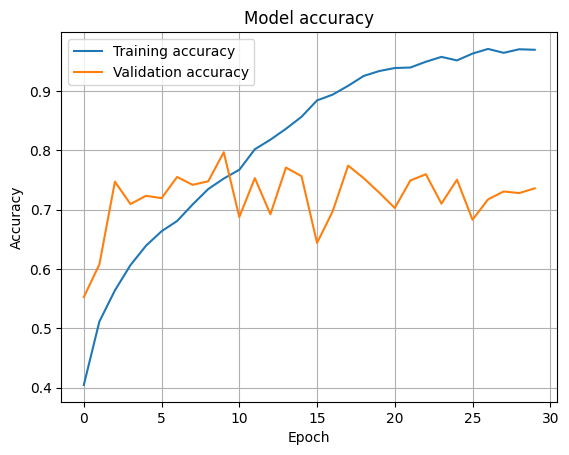

In [ ]:
# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [15]:
#copied from Coursera util package
from keras.preprocessing import image
from sklearn.metrics import roc_auc_score, roc_curve
from tensorflow.compat.v1.logging import INFO, set_verbosity
import cv2

def get_roc_curve(labels, predicted_vals, generator):
    auc_roc_vals = []
    for i in range(len(labels)):
        try:
            gt = generator.labels[:, i]
            pred = predicted_vals[:, i]
            auc_roc = roc_auc_score(gt, pred)
            auc_roc_vals.append(auc_roc)
            fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
            plt.figure(1, figsize=(10, 10))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr_rf, tpr_rf,
                     label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve')
            plt.legend(loc='best')
        except:
            print(
                f"Error in generating ROC curve for {labels[i]}. "
                f"Dataset lacks enough examples."
            )
    plt.show()
    return auc_roc_vals

In [ ]:
preds = vgg16_model.predict_generator(valid_generator)

<ipython-input-27-519d4d513f73>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = vgg16_model.predict_generator(valid_generator)


In [ ]:
import matplotlib.pyplot as plt
auc_rocs = get_roc_curve(labels, preds, valid_generator)

Error in generating ROC curve for MEL. Dataset lacks enough examples.
Error in generating ROC curve for NV. Dataset lacks enough examples.
Error in generating ROC curve for BCC. Dataset lacks enough examples.
Error in generating ROC curve for BKL. Dataset lacks enough examples.
Error in generating ROC curve for UNK. Dataset lacks enough examples.


In [ ]:
y_true, y_pred = [], []
for pred, arr in zip(preds, valid_generator.labels):
    y_true.append(np.argmax(arr))
    y_pred.append(np.argmax(pred))
y_true = np.array(y_true)
y_pred = np.array(y_pred)
print("y_true:", y_true)
print("y_pred:", y_pred)

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):


    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [23]:
from sklearn.metrics import classification_report

In [ ]:
class_labels = list(val_df.columns[1:])  # adjust the index if needed
report = classification_report(y_true, y_pred, target_names=class_labels)

In [ ]:
print(report)

              precision    recall  f1-score   support

         MEL       0.11      0.18      0.14       171
          NV       0.62      0.55      0.59       909
         BCC       0.07      0.05      0.06        93
         BKL       0.15      0.17      0.16       217
         UNK       0.07      0.07      0.07       122

    accuracy                           0.39      1512
   macro avg       0.21      0.20      0.20      1512
weighted avg       0.42      0.39      0.40      1512



In [13]:
vgg16_model_2 = vgg_model(input_shape=(224, 224, 3))

58889256/58889256 [==============================] - 2s 0us/step
Model has compiled


In [14]:
history = vgg16_model_2.fit(train_generator, validation_data=valid_generator, epochs=10)

Epoch 1/10
94/94 [==============================] - 1216s 13s/step - loss: 1.4005 - accuracy: 0.4230 - val_loss: 1.2461 - val_accuracy: 0.5324
Epoch 2/10
94/94 [==============================] - 396s 4s/step - loss: 1.1609 - accuracy: 0.5275 - val_loss: 0.8517 - val_accuracy: 0.6627
Epoch 3/10
94/94 [==============================] - 415s 4s/step - loss: 1.0495 - accuracy: 0.5817 - val_loss: 0.7093 - val_accuracy: 0.7348
Epoch 4/10
94/94 [==============================] - 388s 4s/step - loss: 0.9725 - accuracy: 0.6153 - val_loss: 0.6746 - val_accuracy: 0.7454
Epoch 5/10
94/94 [==============================] - 382s 4s/step - loss: 0.9015 - accuracy: 0.6485 - val_loss: 0.6432 - val_accuracy: 0.7685
Epoch 6/10
94/94 [==============================] - 378s 4s/step - loss: 0.8290 - accuracy: 0.6761 - val_loss: 0.7993 - val_accuracy: 0.6984
Epoch 7/10
94/94 [==============================] - 365s 4s/step - loss: 0.7714 - accuracy: 0.6983 - val_loss: 0.8603 - val_accuracy: 0.6971
Epoch 8/10


In [17]:
vgg16_model_2.save('/content/drive/MyDrive/dataset/vgg16_model_final.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [18]:
preds = vgg16_model_2.predict_generator(valid_generator)

<ipython-input-18-9d01a6a79ea1>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = vgg16_model_2.predict_generator(valid_generator)


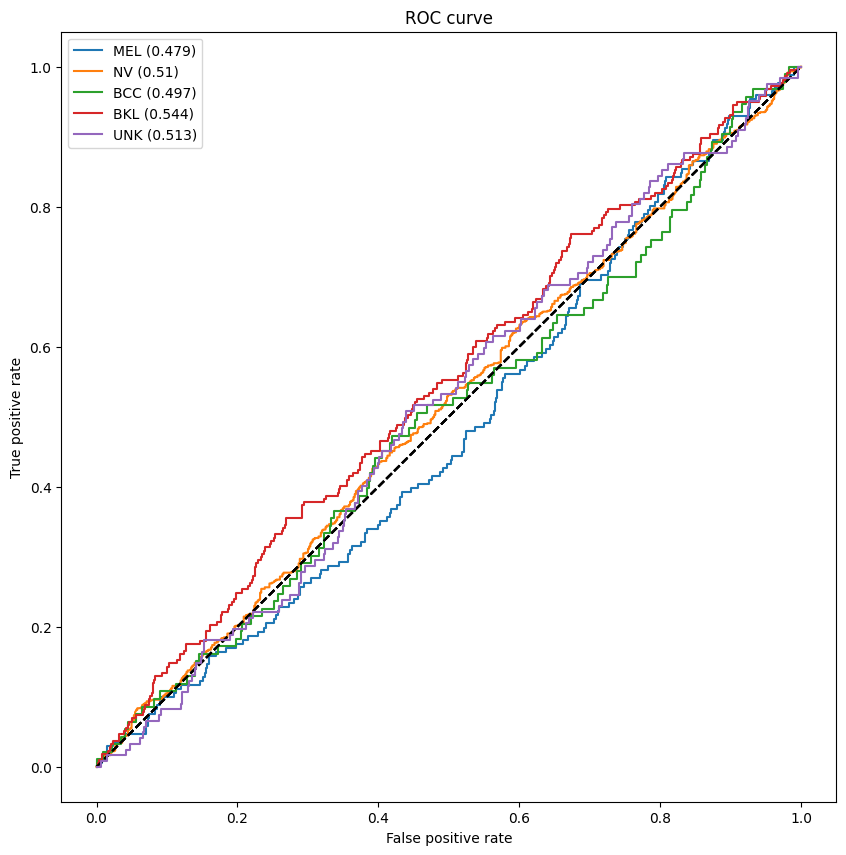

In [20]:
import matplotlib.pyplot as plt

auc_rocs = get_roc_curve(labels, preds, valid_generator)

In [21]:
y_true, y_pred = [], []
for pred, arr in zip(preds, valid_generator.labels):
    y_true.append(np.argmax(arr))
    y_pred.append(np.argmax(pred))
y_true = np.array(y_true)
y_pred = np.array(y_pred)
print("y_true:", y_true)
print("y_pred:", y_pred)

y_true: [1 1 3 ... 4 3 2]
y_pred: [0 4 3 ... 1 3 1]


In [26]:
class_labels = list(val_df.columns[1:])  # adjust the index if needed

report = classification_report(y_true, y_pred, target_names=class_labels)

In [27]:
print(report)

              precision    recall  f1-score   support

         MEL       0.12      0.11      0.11       171
          NV       0.61      0.53      0.57       909
         BCC       0.07      0.10      0.08        93
         BKL       0.16      0.24      0.19       217
         UNK       0.07      0.07      0.07       122

    accuracy                           0.38      1512
   macro avg       0.21      0.21      0.21      1512
weighted avg       0.42      0.38      0.39      1512

